In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
import time
from sklearn.metrics import roc_auc_score

/home/user/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    Occlusion,
    InputXGradient
)


In [3]:
torch.cuda.set_device("cuda:0")
torch.cuda.empty_cache()

In [4]:
split_date=pd.to_datetime("2016-06-01 00:00:00").to_datetime64()


In [5]:
all_tremors_train=[]
all_noise_train=[]
all_earthquakes_train=[]

all_tremors_test=[]
all_noise_test=[]
all_earthquakes_test=[]


In [6]:
tremor_DB_path='/media/user/90209203-bbce-4dd7-a8ae-656f553dcaf5/backup_darwin_storage2/DB_tremor/DB_tremor//'

In [7]:
stations=[['HH','KHBB'],['HH','FISH'],['HH','LCCR'],['HH','LEBA'],['HH','SP2'],['HH','STOR']]#,
#           ['BH','DOSE'],['BH','GNW'],['BH','LEBA'],['BH','LRIV'],
#           ['EH','B001'],['EH','B006'],['EH','B014'],['EH','B018'],['EH','B943'],
#            ['HH','MINN'],['HH','RAIN'],['HH','KHMB'],['HH','KSXB']]



for station in stations:
    print (station)
    #Pour les tremors:
    try:
        with h5py.File(tremor_DB_path+'Database_%s_tremors_%s.hdf5'%(station[0],station[1]), 'r') as f:
            tremors=f["tremors"][:]#[0,1,:,:]
        tremor_times=pd.read_csv(tremor_DB_path+'times_tremors_%s_%s.csv'%(station[0],station[1]),header=None,parse_dates=[0])[:len(tremors)]
        tremors[tremors!=tremors]=0.0
    except:
        tremors=np.empty(1)
        tremor_times=pd.DataFrame([split_date])
        
    #pour le bruit:
    try:
        with h5py.File(tremor_DB_path+'Database_%s_noise_%s.hdf5'%(station[0],station[1]), 'r') as f:
            noise=f["noise"][:]#[0,1,:,:]
        noise_times=pd.read_csv(tremor_DB_path+'times_noise_%s_%s.csv'%(station[0],station[1]),header=None,parse_dates=[0])[:len(noise)]
        noise[noise!=noise]=0.0
    except:
        noise=np.empty(1)
        noise_times=None       
        
    #pour le bruit anthropogenic:
    try:
        with h5py.File(tremor_DB_path+'Database_%s_anthropogenic_%s.hdf5'%(station[0],station[1]), 'r') as f:
            anthropogenic=f["anthropogenic"][:]#[0,1,:,:]
        anthropogenic_times=pd.read_csv(tremor_DB_path+'times_anthropogenic_%s_%s.csv'%(station[0],station[1]),header=None,parse_dates=[0])[:len(anthropogenic)]
        anthropogenic[anthropogenic!=anthropogenic]=0.0
    except:
        anthropogenic=np.empty(1)
        anthropogenic_times=None    
               
    #pour les séismes:
    try:
        with h5py.File(tremor_DB_path+'Database_%s_earthquakes_%s.hdf5'%(station[0],station[1]), 'r') as f:
            earthquakes=f["earthquakes"][:]#[0,1,:,:]
        earthquakes_times=pd.read_csv(tremor_DB_path+'times_earthquakes_%s_%s.csv'%(station[0],station[1]),header=None,parse_dates=[0])[:len(earthquakes)]
        earthquakes[earthquakes!=earthquakes]=0.0
    except:
        earthquakes=np.empty(1)
        earthquakes_times=None     
           


    #Train set
    tremors_train=tremors[np.where(tremor_times.values<split_date)[0]]
    noise_train=noise[np.where(noise_times.values<split_date)[0]]
    
    try:
        anthropogenic_train=anthropogenic[np.where(anthropogenic_times.values<split_date)[0]]
    except:
        anthropogenic_train=[]
    try:
        earthquakes_train=earthquakes[np.where(earthquakes_times.values<split_date)[0]]
    except:
        earthquakes_train=[]
    try:
        noise_train=np.concatenate((anthropogenic_train,noise_train))
    except:
        None

    #test set
    tremors_test=tremors[np.where(tremor_times.values>=split_date)[0]]
    noise_test=noise[np.where(noise_times.values>=split_date)[0]]
    
    try:
        anthropogenic_test=anthropogenic[np.where(anthropogenic_times.values>=split_date)[0]]
    except:
        anthropogenic_test=[]
    try:
        earthquakes_test=earthquakes[np.where(earthquakes_times.values>=split_date)[0]]
    except:
        earthquakes_test=[]
    try:
        noise_test=np.concatenate((anthropogenic_test,noise_test))
    except:
        None

        
    print ("Station %s"%station)
    print ("%i tremors (%i train / %i test)"%(len(tremors),len(tremors_train),len(tremors_test)))
    print ("%i noise (%i train / %i test)"%(len(noise),len(noise_train),len(noise_test)))
    print ("%i anthropogenic (%i train / %i test)"%(len(anthropogenic),len(anthropogenic_train),len(anthropogenic_test)))
    print ("%i earthquakes (%i train / %i test)"%(len(earthquakes),len(earthquakes_train),len(earthquakes_test)))
    print ("\n\n")


            
    if len(noise_train)>0:
        norm_fac=np.quantile(noise_train,0.999)
        bias_fac=np.median(noise_train)

        tremors_train=(tremors_train-bias_fac)/norm_fac
        noise_train=(noise_train-bias_fac)/norm_fac
        earthquakes_train=(earthquakes_train-bias_fac)/norm_fac
        
        tremors_test=(tremors_test-bias_fac)/norm_fac
        noise_test=(noise_test-bias_fac)/norm_fac
        earthquakes_test=(earthquakes_test-bias_fac)/norm_fac

        
#     else:
#         norm_fac=1E-6#np.quantile(tremors_train,0.95)
#         bias_fac=0.0#np.median(tremors_train)

#         tremors_train=(tremors_train-bias_fac)/norm_fac
#         non_tremors_train=(non_tremors_train-bias_fac)/norm_fac
#         tremors_test=(tremors_test-bias_fac)/norm_fac
#         non_tremors_test=(non_tremors_test-bias_fac)/norm_fac        
    if len(tremors_train)>0:
        all_tremors_train.append(tremors_train)
    if len(noise_train)>0:
        all_noise_train.append(noise_train)
    if len(earthquakes_train)>0: 
        all_earthquakes_train.append(earthquakes_train)
    
    if len(tremors_test)>0:
        all_tremors_test.append(tremors_test)
    if len(noise_test)>0:
        all_noise_test.append(noise_test)
    if len(earthquakes_test)>0:
        all_earthquakes_test.append(earthquakes_test)


    


['HH', 'KHBB']
Station ['HH', 'KHBB']
29728 tremors (27065 train / 2663 test)
29153 noise (20605 train / 8548 test)
1 anthropogenic (0 train / 0 test)
312 earthquakes (276 train / 36 test)



['HH', 'FISH']
Station ['HH', 'FISH']
1530 tremors (827 train / 703 test)
4212 noise (1703 train / 2509 test)
1 anthropogenic (0 train / 0 test)
1 earthquakes (0 train / 0 test)



['HH', 'LCCR']
Station ['HH', 'LCCR']
757 tremors (222 train / 535 test)
351 noise (191 train / 160 test)
1 anthropogenic (0 train / 0 test)
1 earthquakes (0 train / 0 test)



['HH', 'LEBA']
Station ['HH', 'LEBA']
1984 tremors (1104 train / 880 test)
3421 noise (1998 train / 1423 test)
1 anthropogenic (0 train / 0 test)
4 earthquakes (0 train / 4 test)



['HH', 'SP2']
Station ['HH', 'SP2']
219 tremors (219 train / 0 test)
210 noise (210 train / 0 test)
1 anthropogenic (0 train / 0 test)
1 earthquakes (0 train / 0 test)



['HH', 'STOR']
Station ['HH', 'STOR']
405 tremors (214 train / 191 test)
356 noise (181 train / 1

In [8]:
earthquakes_train=np.concatenate(tuple(all_earthquakes_train))
earthquakes_test=np.concatenate(tuple(all_earthquakes_test))


In [9]:
tremors_train=np.concatenate(tuple(all_tremors_train))
noise_train=np.concatenate(tuple(all_noise_train))

tremors_test=np.concatenate(tuple(all_tremors_test))
noise_test=np.concatenate(tuple(all_noise_test))


In [10]:
np.random.shuffle(tremors_train)
np.random.shuffle(noise_train)
np.random.shuffle(earthquakes_train)


In [11]:
#np.quantile(tremors_train,0.8)

In [12]:
print (np.quantile(noise_test,0.8),np.quantile(tremors_test,0.8),np.quantile(earthquakes_train,0.8))

0.06734181195497513 0.07690221816301346 0.06457197517156604


In [13]:
print (len(tremors_train)+len(tremors_test),len(noise_train)+len(noise_test),len(earthquakes_train)+len(earthquakes_train))
         

34623 37703 552


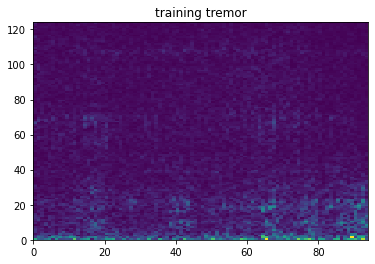

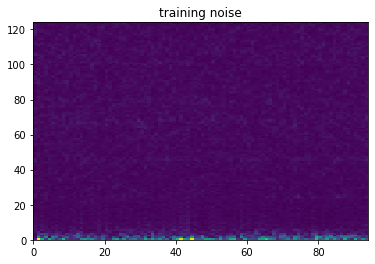

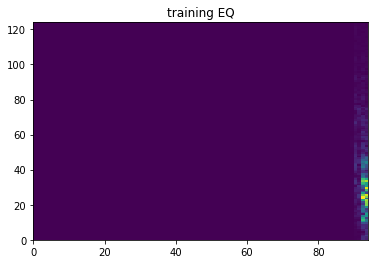

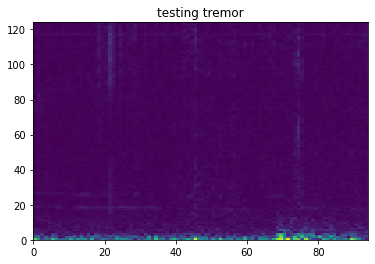

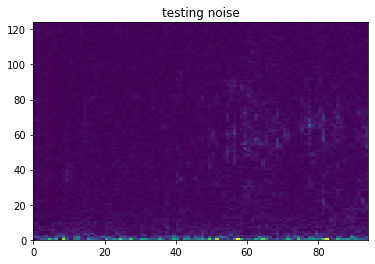

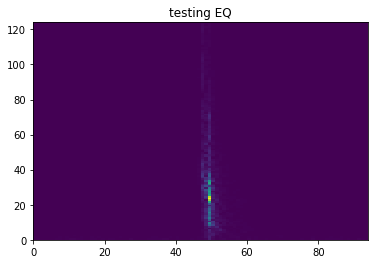

In [14]:
plt.pcolormesh(tremors_train[np.random.randint(len(tremors_train))][0])#,vmin=-1,vmax=1)
plt.title("training tremor")
plt.show()
plt.close()

plt.pcolormesh(noise_train[np.random.randint(len(noise_train))][0])#,vmin=-1,vmax=1)
plt.title("training noise")
plt.show()
plt.close()

plt.pcolormesh(earthquakes_train[np.random.randint(len(earthquakes_train))][0])#,vmin=-1,vmax=1)
plt.title("training EQ")
plt.show()
plt.close()

plt.pcolormesh(tremors_test[np.random.randint(len(tremors_test))][0])#,vmin=-1,vmax=1)
plt.title("testing tremor")
plt.show()
plt.close()

plt.pcolormesh(noise_test[np.random.randint(len(noise_test))][0])#,vmin=-1,vmax=1)
plt.title("testing noise")
plt.show()
plt.close()

plt.pcolormesh(earthquakes_test[np.random.randint(len(earthquakes_test))][0])#,vmin=-1,vmax=1)
plt.title("testing EQ")
plt.show()
plt.close()




In [15]:
def data_generator(batch_size,normalization=True,debug=False):
    while True:
        x=np.empty((batch_size,3, 124, 94),dtype=np.float32)
        y=np.empty((batch_size),dtype=np.float32)#,dtype=np.int)
        
        tremor_index=np.random.randint(len(tremors_train)-batch_size//3)
        x[:batch_size//3]=tremors_train[tremor_index:tremor_index+batch_size//3]
        y[:batch_size//3]=np.zeros(batch_size//3)#,dtype=np.int)
        
        noise_index=np.random.randint(len(noise_train)-batch_size//3)
        x[batch_size//3:2*batch_size//3]=noise_train[noise_index:noise_index+batch_size//3]
        y[batch_size//3:2*batch_size//3]=np.ones(batch_size//3)#,dtype=np.int)

        EQ_index=np.random.randint(len(earthquakes_train)-batch_size//3)
        x[2*batch_size//3:]=earthquakes_train[EQ_index:EQ_index+batch_size//3]
        y[2*batch_size//3:]=2*np.ones(batch_size//3)#,dtype=np.int)

        
        p=np.random.permutation(batch_size)
        x=x[p]
        y=y[p]
        
        if debug: print (x.shape)
        
        x=torch.from_numpy(x).float().cuda()
        y=torch.from_numpy(y).long().cuda()
        
        if normalization:
            for i in range(batch_size):
                for k in range(x.shape[1]):
                    if torch.std(x[i,k])>0.0:
                        x[i,k]=(x[i,k]-torch.mean(x[i,k]))/torch.std(x[i,k])
                
        yield x,y
        
def test_generator(batch_size,normalization=True,debug=False):
    while True:
        x=np.empty((batch_size,3, 124, 94),dtype=np.float32)
        y=np.empty((batch_size),dtype=np.float32)#,dtype=np.int)
        
        tremor_index=np.random.randint(len(tremors_test)-batch_size//3)
        x[:batch_size//3]=tremors_test[tremor_index:tremor_index+batch_size//3]
        y[:batch_size//3]=np.zeros(batch_size//3)#,dtype=np.int)
        
        noise_index=np.random.randint(len(noise_test)-batch_size//3)
        x[batch_size//3:2*batch_size//3]=noise_test[noise_index:noise_index+batch_size//3]
        y[batch_size//3:2*batch_size//3]=np.ones(batch_size//3)#,dtype=np.int)

        EQ_index=np.random.randint(len(earthquakes_test)-batch_size//3)
        x[2*batch_size//3:]=earthquakes_test[EQ_index:EQ_index+batch_size//3]
        y[2*batch_size//3:]=2*np.ones(batch_size//3)#,dtype=np.int)

        
        p=np.random.permutation(batch_size)
        x=x[p]
        y=y[p]
        
        if debug: print (x.shape)
        
        x=torch.from_numpy(x).float().cuda()
        y=torch.from_numpy(y).long().cuda()
        
        if normalization:
            for i in range(batch_size):
                for k in range(x.shape[1]):
                    if torch.std(x[i,k])>0.0:
                        x[i,k]=(x[i,k]-torch.mean(x[i,k]))/torch.std(x[i,k])
                
        yield x,y
        
        
def test_set(batch_size,normalization=True):
    test_size=len(tremors_test)+len(noise_test)+len(earthquakes_test)
    x=np.empty((test_size,3, 124, 94),dtype=np.float32)
    y=np.empty((test_size),dtype=np.float32)#,dtype=np.int)

    x[:len(tremors_test)]=tremors_test
    y[:len(tremors_test)]=np.zeros(len(tremors_test))#,dtype=np.int)

    x[len(tremors_test):len(tremors_test)+len(noise_test)]=noise_test
    y[len(tremors_test):len(tremors_test)+len(noise_test)]=np.ones(len(noise_test))#,dtype=np.int)

    x[len(tremors_test)+len(noise_test):]=earthquakes_test
    y[len(tremors_test)+len(noise_test):]=2*np.ones(len(earthquakes_test))#,dtype=np.int)

    
    p=np.random.permutation(test_size)[:batch_size]
    x=x[p]
    y=y[p]
    
    
    
    x=torch.from_numpy(x).float().cuda()
    y=torch.from_numpy(y).long().cuda()
    
    if normalization:
        for i in range(batch_size):
            for k in range(x.shape[1]):
                    if torch.std(x[i,k])>0.0:
                        x[i,k]=(x[i,k]-torch.mean(x[i,k]))/torch.std(x[i,k])
    return x,y

In [16]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    return h, w

In [17]:
X,y=next(data_generator(9,debug=False))

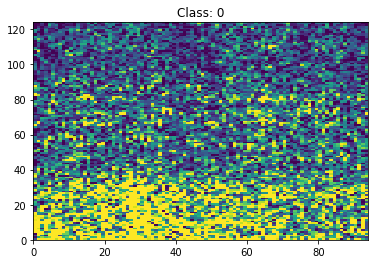

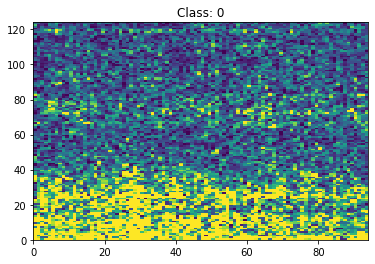

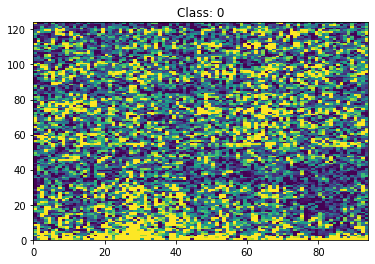

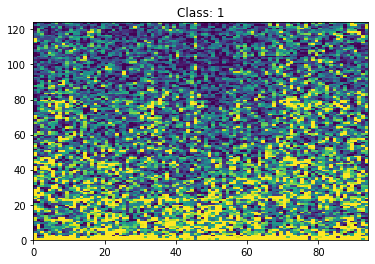

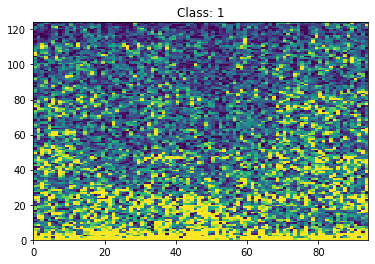

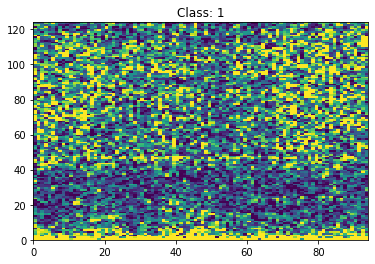

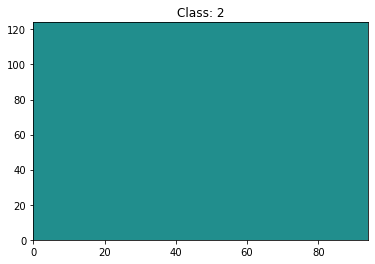

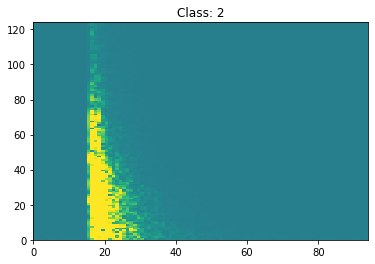

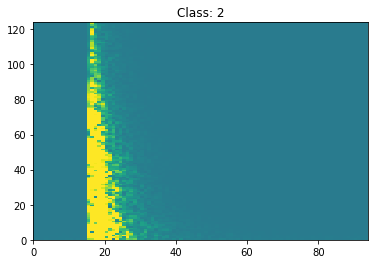

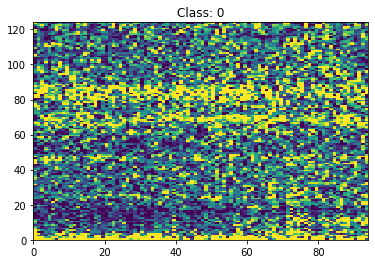

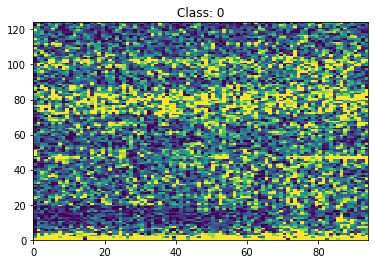

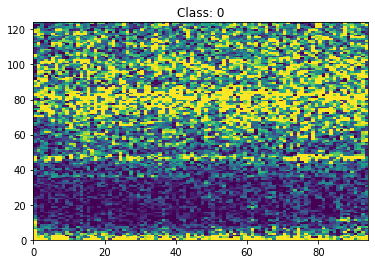

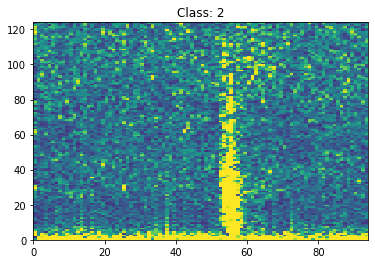

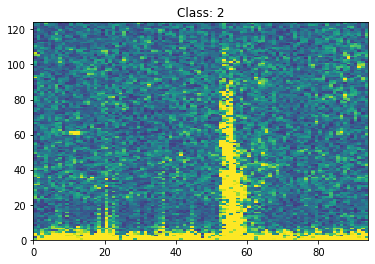

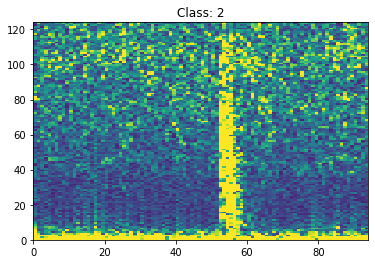

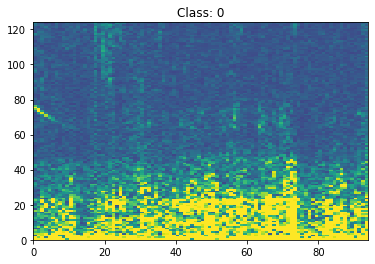

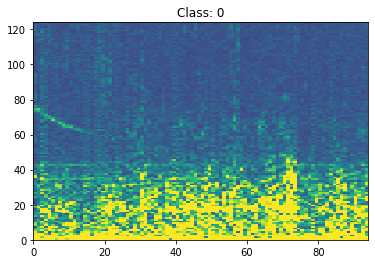

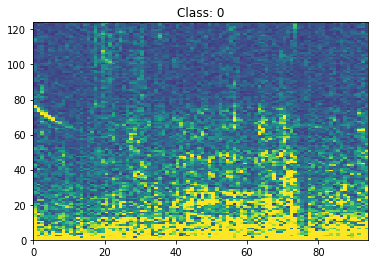

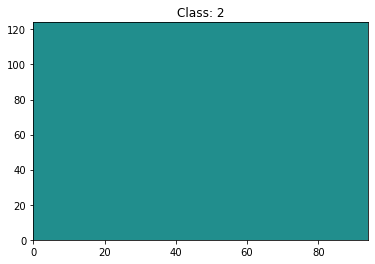

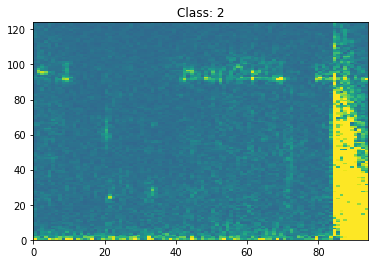

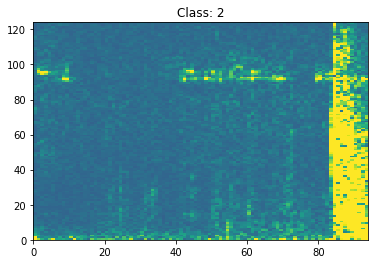

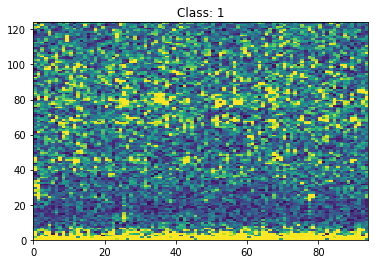

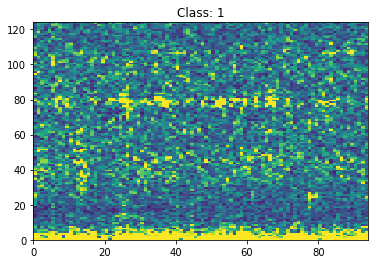

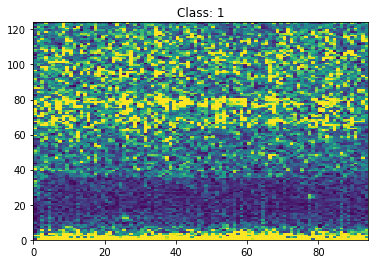

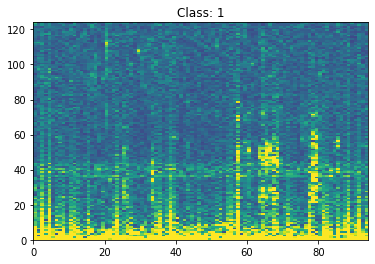

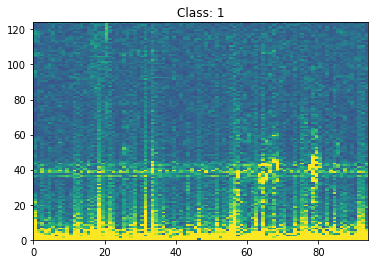

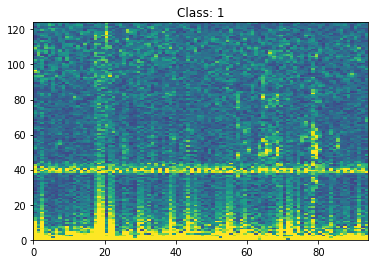

In [18]:
for e,label in zip(X,y):
    for chan in e:
        
        plt.pcolormesh(chan.cpu().numpy(),vmin=-1,vmax=1)
        plt.title("Class: %s"%label.cpu().numpy())
        plt.show()
        plt.close()
    print ("\n\n\n\n\n")


# Adversarial training


In [19]:
nx=124
ny=94
#Filters
nf1=32
nf2=64
nf3=128
#Kernel sizes
ks1=3
ks2=3
ks3=3
dilation=1
#Pooling size
ps1=3
ps2=2
ps3=2
#Number of fully connected neurons
fcn1=180
fcn2=90
#Dropout
drop=0.1


x = F.max_pool2d(F.leaky_relu(nn.Conv2d(3, nf1, ks1,dilation=dilation)(torch.empty([1, 3, 124, 94]).cpu()), negative_slope=0.1), ps1)
x = F.max_pool2d(F.leaky_relu(nn.Conv2d(nf1, nf2, ks2,dilation=dilation)(x), negative_slope=0.1), ps2)
x = F.max_pool2d(F.leaky_relu(nn.Conv2d(nf2, nf3, ks3,dilation=dilation)(x), negative_slope=0.1), ps3)

n_features=x.shape[1]*x.shape[2]*x.shape[3]
print(n_features)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, nf1, ks1,dilation=dilation)
        self.conv2 = nn.Conv2d(nf1, nf2, ks2,dilation=dilation)
        self.conv3 = nn.Conv2d(nf2, nf3, ks3,dilation=dilation)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(n_features, fcn1)  # (((124-3)//3-2)//3)* (((94-3)//3-2)//3)*16

        self.fc2 = nn.Linear(fcn1, fcn2)
        self.fc3 = nn.Linear(fcn2, 3)
        self.dropout1 = nn.Dropout2d(drop)

    def forward(self, x):
        x=self.dropout1(x)
        x = F.max_pool2d(F.leaky_relu(self.conv1(x), negative_slope=0.1), ps1)
        x=self.dropout1(x)
        x = F.max_pool2d(F.leaky_relu(self.conv2(x), negative_slope=0.1), ps2)
        x=self.dropout1(x)
        x = F.max_pool2d(F.leaky_relu(self.conv3(x), negative_slope=0.1), ps3)
        x=self.dropout1(x)
        x = x.view(-1, n_features)
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))#F.log_softmax(self.fc3(x),dim=1)#torch.sigmoid(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




6144


In [20]:
# Different adversarial attacks
def fgsm(model, loss_fn,X, y, epsilon=0.01):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = loss_fn(model(X + delta), y)#nn.BCELoss(reduction='mean')(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()



def epoch(data_generator, loss_fn,batch_size,model, opt=None):
    interpreter = IntegratedGradients(model)
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    X,y=next(data_generator(batch_size))
    yp = model(X)
    loss = 0.8*loss_fn(yp,y)+0.2*interpreter_intersection_loss(interpreter,X)#nn.BCELoss(reduction='mean')(yp,y)
    if opt:
        opt.zero_grad()
        loss.backward()
        opt.step() 
    return loss


def epoch_adversarial(data_generator,loss_fn,batch_size, model, attack, opt=None, **kwargs):
    interpreter = IntegratedGradients(model)
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    X,y=next(data_generator(batch_size))
    delta = attack(model, loss_fn,X, y, **kwargs)
    yp = model(X+delta)
    loss = 0.8*loss_fn(yp,y)+0.2*interpreter_intersection_loss(interpreter,X)#nn.BCELoss(reduction='mean')(yp,y)
    if opt:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss


In [21]:
torch.cuda.empty_cache()


net_robust = Net().cuda()
#net.cuda()
print(net_robust)

net_robust.train()

model_parameters = filter(lambda p: p.requires_grad, net_robust.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print ('%i trainable parameters'%params)
torch.backends.cudnn.benchmark = True

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6144, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=3, bias=True)
  (dropout1): Dropout2d(p=0.1, inplace=False)
)
1215911 trainable parameters


In [22]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input.shape,target.shape)
torch.nn.CrossEntropyLoss()(input,target)

torch.Size([3, 5]) torch.Size([3])


tensor(1.6549, grad_fn=<NllLossBackward0>)

In [23]:
cross_entropy_loss=torch.nn.BCELoss().cuda()

def interpreter_intersection_loss(interpreter,X):
    attribution0 = (F.relu(interpreter.attribute(X,internal_batch_size=4,n_steps=10,target=0).float())>0.0).float()
    attribution0.requires_grad=True
    attribution1 = (F.relu(interpreter.attribute(X,internal_batch_size=4,n_steps=10,target=1).float())>0.0).float()
    attribution2 = (F.relu(interpreter.attribute(X,internal_batch_size=4,n_steps=10,target=2).float())>0.0).float()
    attribution1.requires_grad=False
    attribution2.requires_grad=False

    return -1.0*cross_entropy_loss(attribution0,attribution1)-1.0*cross_entropy_loss(attribution0,attribution2)
    
    


In [24]:
training=False

In [25]:
optimizer = torch.optim.Adam(net_robust.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss().cuda()
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9, patience=3000, threshold=0.0001,min_lr=1E-7, verbose=True)
print_every=10
batch_size=180
val_size=3600
loss_history=[]
best_score = 1.0
best_epoch=0
attack=fgsm

if training:

    for t in range(30000):
        # Forward pass: Compute predicted y by passing x to the model

        loss = epoch_adversarial(data_generator,loss_fn, batch_size,net_robust, attack, optimizer)

        if t % print_every == print_every-1:
            net_robust.eval()
            torch.cuda.empty_cache()

            # Compute and print val loss    
            with torch.no_grad():
                val_loss = epoch(test_generator, loss_fn,val_size,net_robust)
                #adv_loss = epoch_adversarial(test_generator, val_size,net_robust, attack)
                scheduler.step(val_loss)

                #print("Epoch %i: train loss=%.5g val loss=%.5g val adversarial loss=%.5g"%(t,loss.item(),val_loss.item(),adv_loss.item()))
                print("Epoch %i: train loss=%.5g val loss=%.5g"%(t,loss.item(),val_loss.item()))

                loss_history.append([t,loss.item(),val_loss.item()])#,adv_loss.item()])

                if val_loss.item() < best_score:
                    best_score = val_loss.item()
                    best_epoch=t
                    torch.save(net_robust.state_dict(), 'tremornet_3classes_interpreterIOU.tar')
                    print("Saving model...")
                net_robust.train()

    

In [26]:
torch.cuda.empty_cache()
cpu = torch.device('cpu')
trained_net_robust = Net()
trained_net_robust.load_state_dict(torch.load('tremornet_3classes_interpreterIOU.tar', map_location=cpu))

trained_net_robust.eval()

with torch.no_grad():
    X,y=test_set(9999)#next(data_generator(999))
    y_pred = trained_net_robust(X.cpu())
    
# 0 - tremor ; 1 - noise ; 2 - EQ
Y_pred_tremor= F.softmax(y_pred)[:,0].numpy()
Y_pred_noise= F.softmax(y_pred)[:,1].numpy()
Y_pred_EQ= F.softmax(y_pred)[:,2].numpy()

y_tremor=np.array([1 if yi==0 else 0 for yi in y.cpu().numpy()])
y_EQ=np.array([1 if yi==2 else 0 for yi in y.cpu().numpy()])



fpr_tremor_train, tpr_tremor_train, _ = roc_curve(y_tremor, Y_pred_tremor)
fpr_EQ_train, tpr_EQ_train, _ = roc_curve(y_EQ, Y_pred_EQ)


/tmp/ipykernel_1875890/2711510708.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Y_pred_tremor= F.softmax(y_pred)[:,0].numpy()
/tmp/ipykernel_1875890/2711510708.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Y_pred_noise= F.softmax(y_pred)[:,1].numpy()
/tmp/ipykernel_1875890/2711510708.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Y_pred_EQ= F.softmax(y_pred)[:,2].numpy()


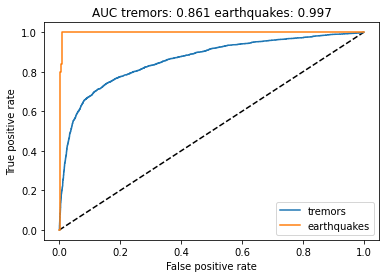

In [27]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_tremor_train, tpr_tremor_train,label='tremors')
plt.plot(fpr_EQ_train, tpr_EQ_train,label='earthquakes')
plt.legend(loc='best')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC tremors: %.3g earthquakes: %.3g'%(roc_auc_score(y_tremor, Y_pred_tremor),roc_auc_score(y_EQ, Y_pred_EQ)))

plt.show()
plt.close()

In [28]:
torch.cuda.empty_cache()
torch.cuda.set_device("cuda:0")

trained_net_robust = Net()
trained_net_robust.load_state_dict(torch.load('tremornet_3classes_interpreterIOU.tar'))

trained_net_robust.eval()
trained_net_robust.cuda()

with torch.no_grad():
    x_test,y_test=next(test_generator(9))#test_set(21)#next(test_generator(10000))
    y_pred_test = trained_net_robust(x_test)#.cpu())


/home/user/anaconda3/envs/pytorch/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 9 equal to the number of examples.
  warnings.warn(


Example 0


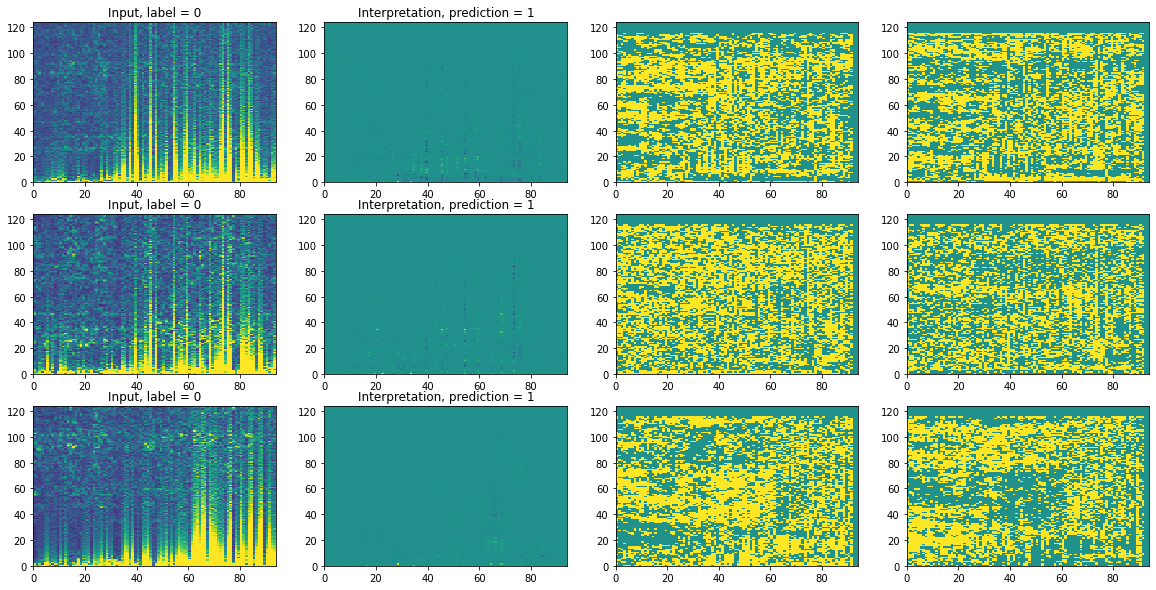

Example 1


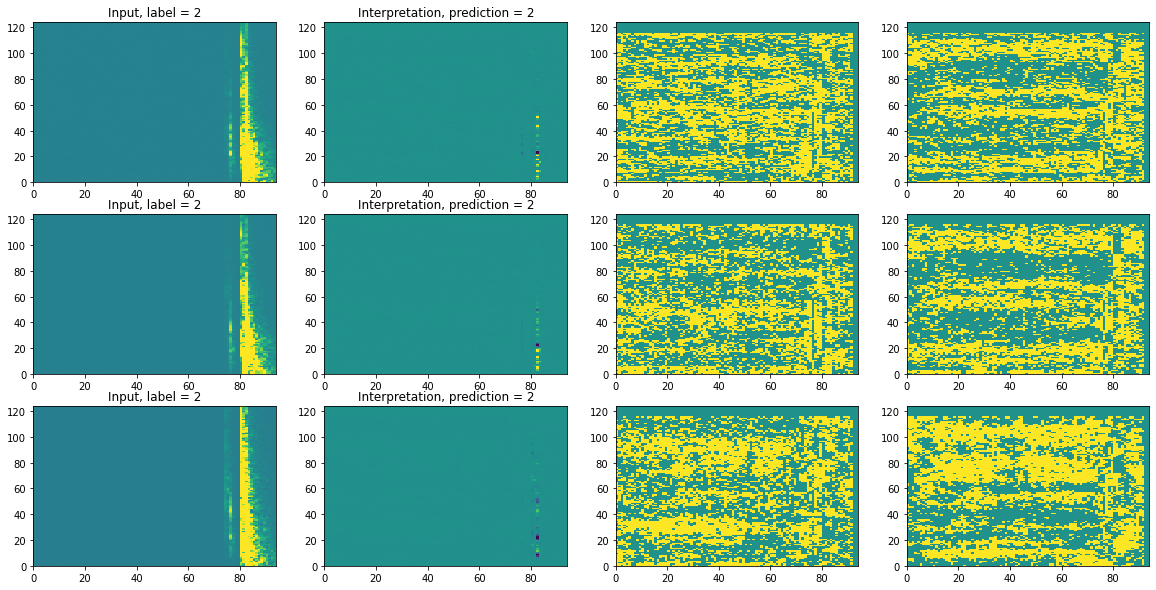

Example 2


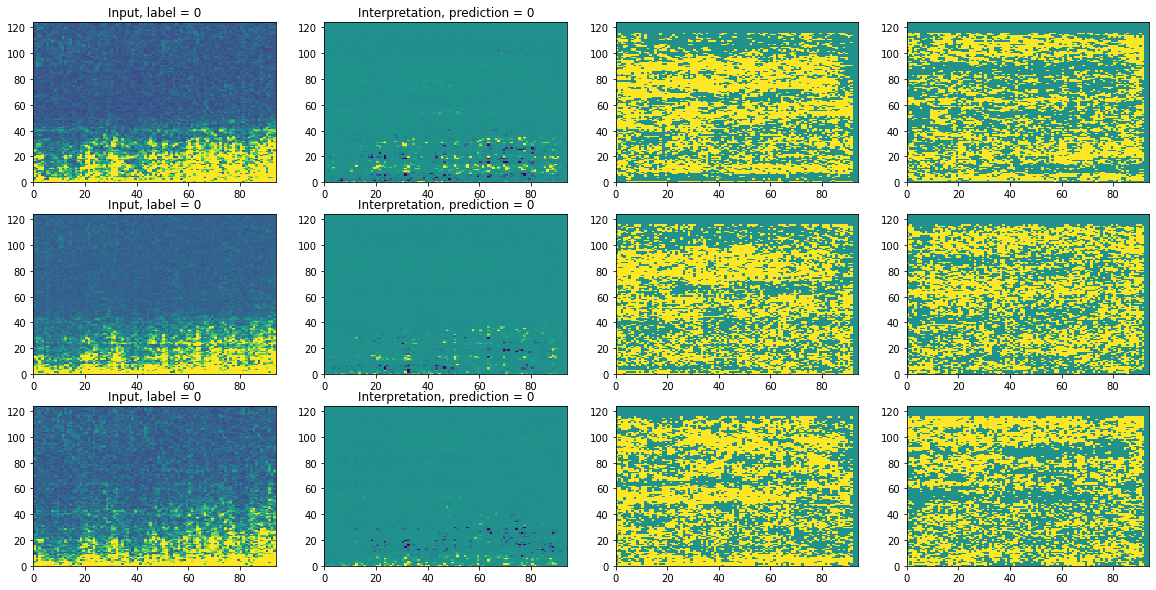

Example 3


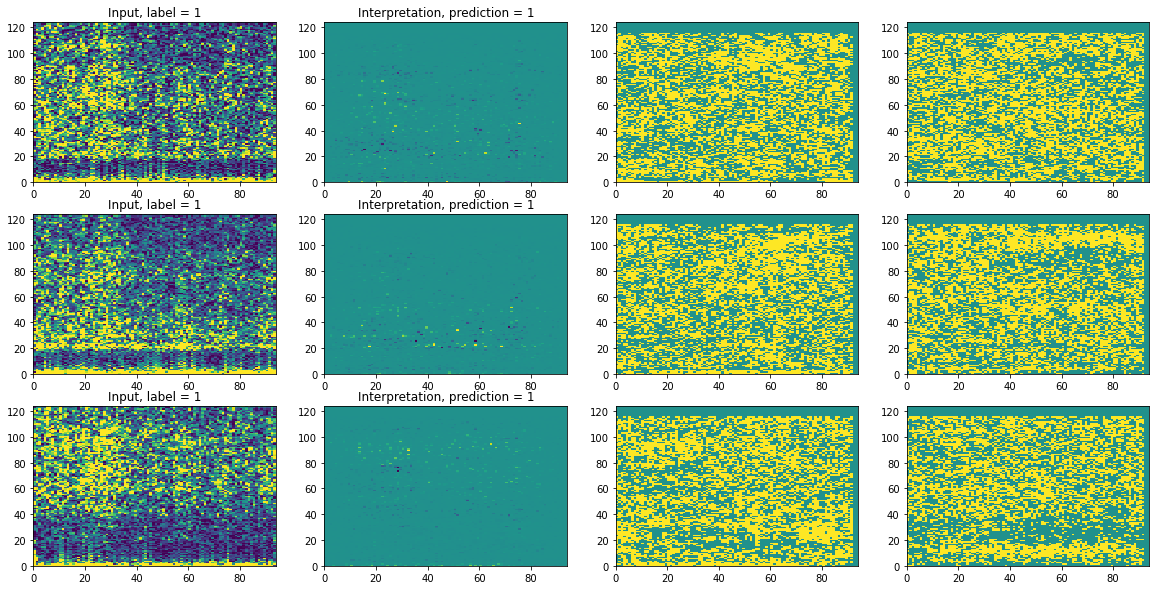

Example 4


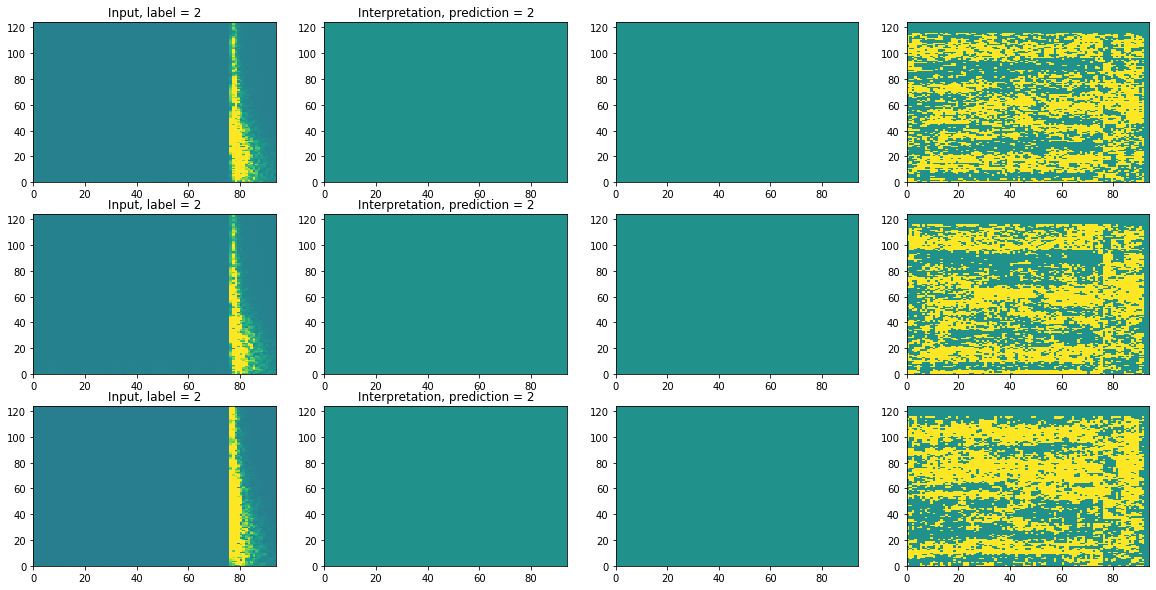

Example 5


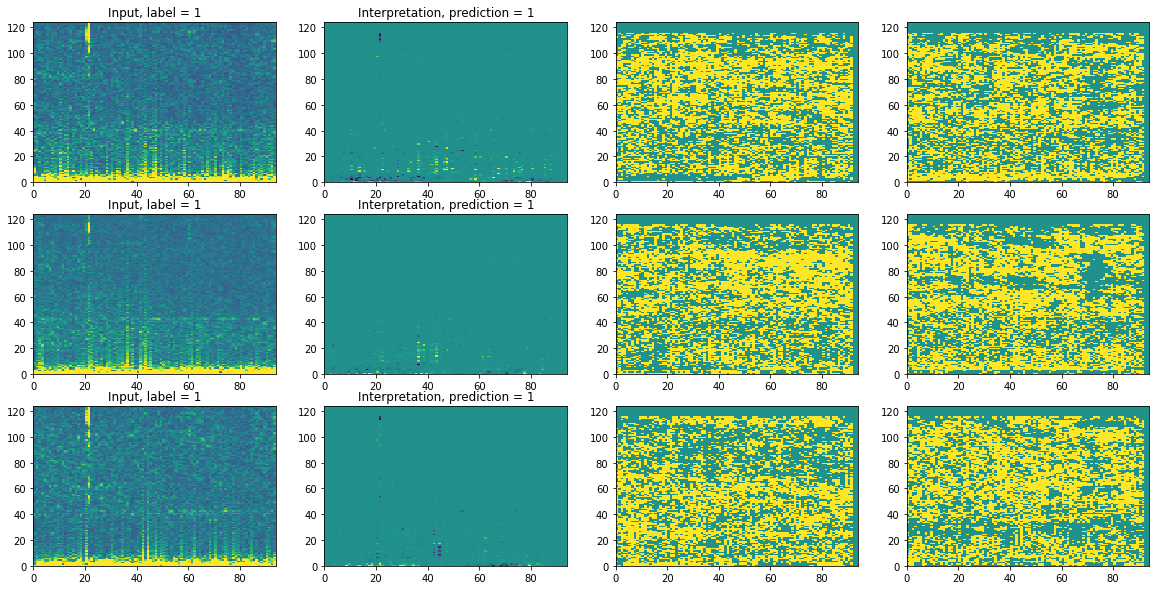

Example 6


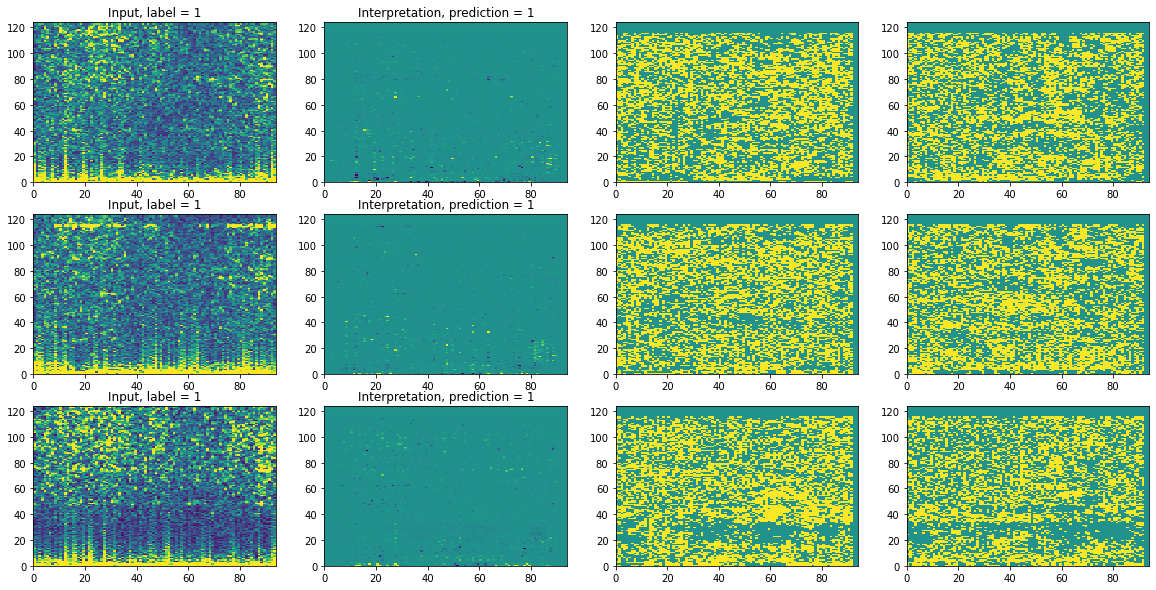

Example 7


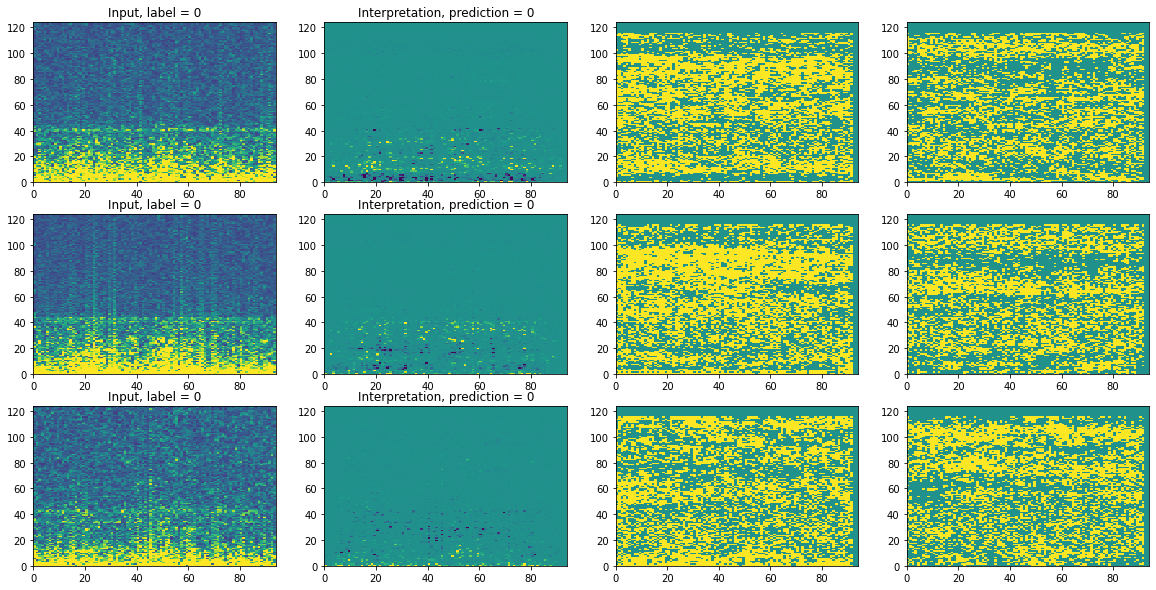

Example 8


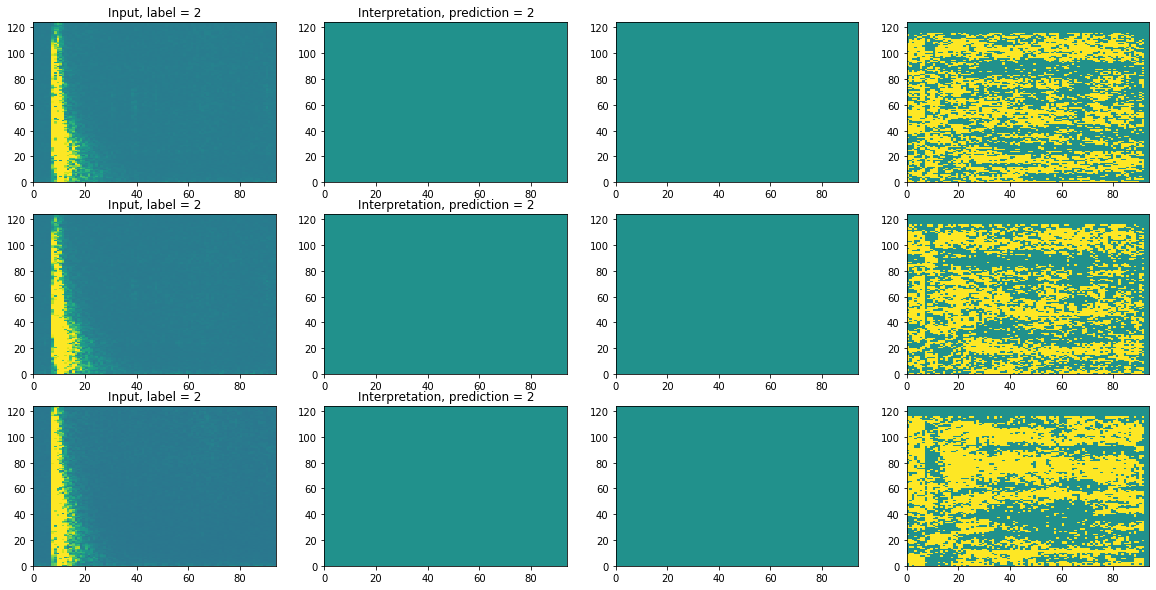

In [29]:

interpreter = IntegratedGradients(trained_net_robust)
attribution0 = interpreter.attribute(x_test,internal_batch_size=4,n_steps=10,target=0)#.float()#.detach()
attribution2 = interpreter.attribute(x_test,internal_batch_size=4,n_steps=10,target=2)#.float()#.detach()

attrib_norm=np.quantile(attribution0.cpu().numpy(),0.999)
attrib_norm_torch=torch.Tensor([attrib_norm]).cuda()

x_test_clean0=(F.relu(attribution0)>0.0).int().float()
x_test_clean2=(F.relu(attribution2)>0.0).int().float()




for i in range(len(x_test)):
    print ("Example %i"%i)
    fig, axes = plt.subplots(3, 4,figsize=(20,10))

    for j in range(3):
        
#         axes[j,0].plot(np.arange(waveform.shape[1])/40.0,waveform[j].cpu().numpy())
        
        axes[j,0].pcolormesh(x_test[i,j].cpu().numpy(),vmin=-1,vmax=1)
        axes[j,0].set_title("Input, label = %i"%y_test[i].cpu().numpy())
        
        im=axes[j,1].pcolormesh(attribution0[i,j].cpu().numpy(),vmin=-attrib_norm,vmax=attrib_norm)
        axes[j,1].set_title("Interpretation, prediction = %i"%np.argmax(y_pred_test[i].cpu().numpy()))
        #plt.colorbar(im, ax=axes[j,1])  
        
        axes[j,2].pcolormesh(x_test_clean0[i,j].cpu().numpy(),vmin=-1,vmax=1)
        axes[j,3].pcolormesh(x_test_clean2[i,j].cpu().numpy(),vmin=-1,vmax=1)

    plt.show()
    plt.close()
